In [1]:
import simcat
import toytree
import itertools as itt
import h5py
import numpy as np
import ipyparallel as ipp
import toyplot
from keras.models import Sequential
from keras.layers import Dense
import seaborn as sns
from matplotlib import pyplot as plt
from numba import jit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
## generate a random tree
tree = toytree.rtree.unittree(ntips=7, treeheight=3, seed=12345)
c, a = tree.draw(tree_style='c',node_labels=tree.get_node_values('name',show_root=True,show_tips=True))

<svg class="toyplot-canvas-Canvas" height="275.0px" id="tf788a228bf3a4f9b99241ee66a5f81aa" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 275.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r3 r0 r5 r1 r6 r4 r2 7 8 9 10 11 12 0.00 1.50 3.00

## read in the simulated data:

In [3]:
dbfile = h5py.File('./databases/mar5_2019_sims10000trees.hdf5')

## flatten and scale X (this takes a while)

In [4]:
X = np.array([i.flatten() for i in dbfile['counts']])

scaler = StandardScaler()
scaledX = scaler.fit_transform(X)

## start preparing the label array

In [5]:
admixinfo = np.hstack([dbfile['admix_sources'][:],
dbfile['admix_targets'][:],
dbfile['admix_props'][:],
dbfile['admix_times'][:]])

## identify cases where gene flow was between sisters

In [6]:
tree = toytree.tree(dbfile.attrs['tree'])
sisters = []
for i in tree.treenode.traverse():
    if len(i.get_children()):
        sisters.append(np.sort([int(i.get_children()[0].name),int(i.get_children()[1].name)]))
sister_ids = np.array([''.join(i.astype(str)) for i in sisters])
rawYedges = np.array([''.join(i) for i in np.sort(admixinfo[:,0:2],axis=1).astype(int).astype(str)])
Ysisters = np.array([i in sister_ids for i in rawYedges])

In [7]:
total_admix = admixinfo[:,2]

## set label to zero if gene flow happened between sisters or didn't happen at all

In [8]:
total_admix[Ysisters] = 0

## set label to one if there was gene flow between non-sister

In [9]:
Y = (total_admix > 0).astype(np.int8)

## define our model

In [14]:
# define the model
def reg_model():
    # create model
    model = Sequential()
    model.add(Dense(1000, input_dim=8960, kernel_initializer='normal', activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal',activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model
currmod = reg_model()

Instructions for updating:
Colocations handled automatically by placer.


## run 50 epochs of fitting

In [15]:
currmod.fit(scaledX[:650000], Y[:650000], epochs=50, batch_size=20000)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
650000/650000 [==============================] - 35s 54us/step - loss: 0.5407 - acc: 0.7261
Epoch 2/50
650000/650000 [==============================] - 35s 53us/step - loss: 0.4976 - acc: 0.7441
Epoch 3/50
650000/650000 [==============================] - 33s 51us/step - loss: 0.4867 - acc: 0.7442
Epoch 4/50
650000/650000 [==============================] - 33s 51us/step - loss: 0.4811 - acc: 0.7443
Epoch 5/50
650000/650000 [==============================] - 35s 54us/step - loss: 0.4773 - acc: 0.7445
Epoch 6/50
650000/650000 [==============================] - 34s 52us/step - loss: 0.4745 - acc: 0.7453
Epoch 7/50
650000/650000 [==============================] - 34s 52us/step - loss: 0.4710 - acc: 0.7454
Epoch 8/50
650000/650000 [==============================] - 33s 51us/step - loss: 0.4686 - acc: 0.7460
Epoch 9/50
650000/650000 [==============================] - 33s 51us/step - loss: 0.4671 - acc: 0.7465
Epoch 10/50
650000/650000

## we're improving -- now run 150 epochs to finish it off.

In [16]:
currmod.fit(scaledX[:650000], Y[:650000], epochs=150, batch_size=20000)

Epoch 1/150
650000/650000 [==============================] - 33s 51us/step - loss: 0.3410 - acc: 0.8311
Epoch 2/150
650000/650000 [==============================] - 33s 51us/step - loss: 0.3470 - acc: 0.8264
Epoch 3/150
650000/650000 [==============================] - 33s 51us/step - loss: 0.3368 - acc: 0.8325
Epoch 4/150
650000/650000 [==============================] - 33s 51us/step - loss: 0.3467 - acc: 0.8262
Epoch 5/150
650000/650000 [==============================] - 33s 51us/step - loss: 0.3333 - acc: 0.8356
Epoch 6/150
650000/650000 [==============================] - 33s 51us/step - loss: 0.3316 - acc: 0.8366
Epoch 7/150
650000/650000 [==============================] - 33s 51us/step - loss: 0.3268 - acc: 0.8395
Epoch 8/150
650000/650000 [==============================] - 33s 51us/step - loss: 0.3195 - acc: 0.8435
Epoch 9/150
650000/650000 [==============================] - 33s 51us/step - loss: 0.3129 - acc: 0.8486
Epoch 10/150
650000/650000 [==============================] - 33

650000/650000 [==============================] - 34s 52us/step - loss: 0.1545 - acc: 0.9361
Epoch 80/150
650000/650000 [==============================] - 33s 50us/step - loss: 0.2036 - acc: 0.9084
Epoch 81/150
650000/650000 [==============================] - 33s 51us/step - loss: 0.1677 - acc: 0.9278
Epoch 82/150
650000/650000 [==============================] - 33s 52us/step - loss: 0.1475 - acc: 0.9400
Epoch 83/150
650000/650000 [==============================] - 33s 51us/step - loss: 0.1508 - acc: 0.9378
Epoch 84/150
650000/650000 [==============================] - 33s 51us/step - loss: 0.2223 - acc: 0.9004
Epoch 85/150
650000/650000 [==============================] - 33s 51us/step - loss: 0.1912 - acc: 0.9144
Epoch 86/150
650000/650000 [==============================] - 33s 51us/step - loss: 0.1843 - acc: 0.9197
Epoch 87/150
650000/650000 [==============================] - 33s 50us/step - loss: 0.2034 - acc: 0.9084
Epoch 88/150
650000/650000 [==============================] - 33s 51

## make predictions and evaluate accuracy:

In [19]:
preds = currmod.predict(scaledX[650000:])

In [28]:
accuracy = 1-float(np.sum((np.round(preds).ravel() == Y[650000:]) == False)) / len(Y[650000:])
accuracy

0.6918666666666666

## so after needing 200 epochs of training, we achieve pretty poor accuracy toward determining if introgression has occurred.

In [27]:
toyplot.matrix(confusion_matrix(Y[650000:],np.round(preds)));

<svg class="toyplot-canvas-Canvas" height="600px" id="t9b6a69c8314b47d6aa741d953a986fbe" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 600 600" width="600px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0 1 0 2748.000000 4883.000000 1 4361.000000 18008.000000

In [29]:
incorrect_idxs = (np.round(preds).ravel() == Y[650000:]) == False

In [33]:
total_admix_wrong = total_admix[650000:][incorrect_idxs]
np.mean(total_admix_wrong[total_admix_wrong != 0])

0.1191127714466588

In [34]:
np.mean(total_admix[650000:][total_admix[650000:] != 0])

0.13994235077222084

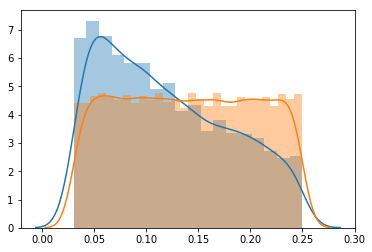

In [38]:
# this is the distribution of "total admixture" from the incorrect predictions
sns.distplot(total_admix_wrong[total_admix_wrong != 0])
# this is the distribution of "total admixture" straight from the simulations
sns.distplot(total_admix[650000:][total_admix[650000:] != 0])
plt.show();

## let's see our accuracy when the introgression proportion was greater than 0.2:

In [51]:
preds = currmod.predict(scaledX[650000:][total_admix[650000:] > .2])

In [59]:
1 - float(np.sum(np.round(preds) == 0))/len(preds)

0.8842084639498433

## much better.

#  

# let's open a bigger dataset and try predicting which specific edges are involved.

## here, total admix is confined to a mass migration of prop 0.1-0.4

In [6]:
dbfile = h5py.File('./databases/mar7_2019_sims15000trees.hdf5')

In [24]:
dbfile['counts']

<HDF5 dataset "counts": shape (1020000, 35, 16, 16), type "<f4">

### this is too big to pull in directly. First, let's pull in a big chunk of it to figure out, e.g., how many classes.

### prep our feature data:

In [7]:
X = np.array([i.flatten() for i in dbfile['counts'][:250000]])

In [8]:
scaler = StandardScaler()
scaledX = scaler.fit_transform(X)

### prep our label data:

In [9]:
admixinfo = np.hstack([dbfile['admix_sources'][:250000],
dbfile['admix_targets'][:250000],
dbfile['admix_props'][:250000],
dbfile['admix_times'][:250000]])

### adjust our label data to account for sister lineages, and make a dictionary of edges involved in introgression

In [10]:
tree = toytree.tree(dbfile.attrs['tree'])
sisters = []
for i in tree.treenode.traverse():
    if len(i.get_children()):
        sisters.append(np.sort([int(i.get_children()[0].name),int(i.get_children()[1].name)]))
sister_ids = np.array([''.join(i.astype(str)) for i in sisters])
rawYedges = np.array([''.join(i) for i in np.sort(admixinfo[:,0:2],axis=1).astype(int).astype(str)])
Ysisters = np.array([i in sister_ids for i in rawYedges])
total_admix = admixinfo[:,2]
total_admix[Ysisters] = 0

edgedict = dict(enumerate(np.unique(rawYedges)))
noneidx = len(edgedict)
edgedict[noneidx] = 'None'
invedgedict = {v: k for k, v in edgedict.items()}
labels = np.array([invedgedict[i] for i in rawYedges])
labels[total_admix == 0] = noneidx

### (we need our label encoder function...)

In [ ]:
@jit(nopython=True)
def encode_labels(labels,empty_arr):
    counter = 0
    for i in labels:
        empty_arr[counter][i] = 1
        counter = counter + 1
    return(empty_arr)

In [11]:
Yencoded = np.zeros((len(labels),49),dtype=np.int8)

In [13]:
Yencoded = encode_labels(labels, Yencoded)

### this gives you a sense for the label distribution. It's a bit uneven. We might expect this for this null, though?

In [10]:
np.sum(Yencoded,axis=0)

array([    0,  1129,  7132,  7153,  7139,  6337,  7111,   866,     0,
        1129,  7129,  7136,  7128,  6736,  7152,  1729,  2390,  7118,
        3551,  3565,  7117,     0,  3437,  2398,     0,  7134,  7140,
        5396,  3665,  2381,  7128,  7123,  5425,  1848,  2225,     0,
        6031,  4747,  2360,  2215,  5994,  4751,  4719,  2390,  3448,
        4901,     0,  4919, 49478])

## start training

In [14]:
# number of times to go through all 1000000 training labels
num_epochs = 30

In [15]:
# max index to use for training
max_idx = 1000000
# the size of "big batches" that will be pulled out from the hdf5 at once
big_batch_size = 200000

### now we can define our model. We had to do the initial data prep above to figure out what size input and (especially) output to expect for this.

In [16]:
# define the model
def reg_model2():
    # create model
    model = Sequential()
    model.add(Dense(1000, input_dim=8960, kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(noneidx+1, kernel_initializer='normal',activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model
currmod = reg_model2()

## the code below runs a set of big epochs, which take random big chunks from the hdf5 (one big epoch in this case runs through all 1000000 training labels), and then trains one "normal" epoch on them with batch sizes of 20000

In [17]:
for ep in np.arange(num_epochs):
    trigger = 0
    counter = 0
    adder = 0
    adder += big_batch_size
    idx_shuff=np.arange(max_idx)
    np.random.shuffle(idx_shuff)
    while not trigger:

        whichidxs_int = idx_shuff[counter:(counter+adder)]
        
        whichidxs = np.zeros((max_idx),dtype=np.bool)
        whichidxs[whichidxs_int] = True
        
        print('prepping data...')
        
        X = np.array([i.flatten() for i in dbfile['counts'][:max_idx][whichidxs]])
        scaler = StandardScaler()
        scaledX = scaler.fit_transform(X)

        admixinfo = np.hstack([dbfile['admix_sources'][:max_idx][whichidxs],
        dbfile['admix_targets'][:max_idx][whichidxs],
        dbfile['admix_props'][:max_idx][whichidxs],
        dbfile['admix_times'][:max_idx][whichidxs]])

        tree = toytree.tree(dbfile.attrs['tree'])
        sisters = []
        for i in tree.treenode.traverse():
            if len(i.get_children()):
                sisters.append(np.sort([int(i.get_children()[0].name),int(i.get_children()[1].name)]))
        sister_ids = np.array([''.join(i.astype(str)) for i in sisters])
        rawYedges = np.array([''.join(i) for i in np.sort(admixinfo[:,0:2],axis=1).astype(int).astype(str)])
        Ysisters = np.array([i in sister_ids for i in rawYedges])
        total_admix = admixinfo[:,2]
        total_admix[Ysisters] = 0

        edgedict = dict(enumerate(np.unique(rawYedges)))
        noneidx = len(edgedict)
        edgedict[noneidx] = 'None'
        invedgedict = {v: k for k, v in edgedict.items()}
        labels = np.array([invedgedict[i] for i in rawYedges])
        labels[total_admix == 0] = noneidx

        Yencoded = np.zeros((len(labels),49),dtype=np.int8)
        Yencoded = encode_labels(labels, Yencoded)
        print('done prepping... now fitting!')
        currmod.fit(scaledX, Yencoded, epochs=1, batch_size=20000)
        print('done fitting ' + str(counter) +' through ' + str(counter+adder) + "!")
        counter += adder
        
        if (counter + adder) > max_idx:
            adder = max_idx - counter
        if counter == max_idx:
            trigger = 1
            print('moving to next big epoch after next round!')
        
    print("Done with full epoch " + str(ep))

prepping data...
done prepping... now fitting!
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
200000/200000 [==============================] - 13s 64us/step - loss: 3.2198 - acc: 0.2350
done fitting 0 through 200000!
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 11s 54us/step - loss: 2.5616 - acc: 0.3642
done fitting 200000 through 400000!
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 11s 53us/step - loss: 2.2134 - acc: 0.4161
done fitting 400000 through 600000!
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 11s 55us/step - loss: 2.0305 - acc: 0.4433
done fitting 600000 through 800000!
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 11s 54us/step - loss: 1.9328 - acc: 0.4574
done fitting 800000 through 1000000!
moving to next big epoch after 

200000/200000 [==============================] - 11s 54us/step - loss: 1.6074 - acc: 0.5238
done fitting 0 through 200000!
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 11s 54us/step - loss: 1.6070 - acc: 0.5215
done fitting 200000 through 400000!
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 11s 55us/step - loss: 1.6139 - acc: 0.5213
done fitting 400000 through 600000!
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 11s 54us/step - loss: 1.6215 - acc: 0.5192
done fitting 600000 through 800000!
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 11s 54us/step - loss: 1.6151 - acc: 0.5213
done fitting 800000 through 1000000!
moving to next big epoch after next round!
Done with full epoch 8
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000

done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 10s 52us/step - loss: 1.5541 - acc: 0.5352
done fitting 400000 through 600000!
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 10s 52us/step - loss: 1.5628 - acc: 0.5325
done fitting 600000 through 800000!
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 10s 52us/step - loss: 1.5619 - acc: 0.5315
done fitting 800000 through 1000000!
moving to next big epoch after next round!
Done with full epoch 16
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 10s 52us/step - loss: 1.5424 - acc: 0.5386
done fitting 0 through 200000!
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 10s 52us/step - loss: 1.5450 - acc: 0.5381
done fitting 200000 through 400000!
prepping data...
done preppin

200000/200000 [==============================] - 10s 51us/step - loss: 1.5249 - acc: 0.5407
done fitting 600000 through 800000!
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 10s 52us/step - loss: 1.5236 - acc: 0.5421
done fitting 800000 through 1000000!
moving to next big epoch after next round!
Done with full epoch 24
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 11s 53us/step - loss: 1.5029 - acc: 0.5471
done fitting 0 through 200000!
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 10s 51us/step - loss: 1.5155 - acc: 0.5450
done fitting 200000 through 400000!
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/200000 [==============================] - 10s 52us/step - loss: 1.5126 - acc: 0.5446
done fitting 400000 through 600000!
prepping data...
done prepping... now fitting!
Epoch 1/1
200000/20000

## now let's read in some test data:

In [19]:
X = np.array([i.flatten() for i in dbfile['counts'][1000000:1020000]])
scaler = StandardScaler()
scaledX = scaler.fit_transform(X)

admixinfo = np.hstack([dbfile['admix_sources'][1000000:1020000],
dbfile['admix_targets'][1000000:1020000],
dbfile['admix_props'][1000000:1020000],
dbfile['admix_times'][1000000:1020000]])

tree = toytree.tree(dbfile.attrs['tree'])
sisters = []
for i in tree.treenode.traverse():
    if len(i.get_children()):
        sisters.append(np.sort([int(i.get_children()[0].name),int(i.get_children()[1].name)]))
sister_ids = np.array([''.join(i.astype(str)) for i in sisters])
rawYedges = np.array([''.join(i) for i in np.sort(admixinfo[:,0:2],axis=1).astype(int).astype(str)])
Ysisters = np.array([i in sister_ids for i in rawYedges])
total_admix = admixinfo[:,2]
total_admix[Ysisters] = 0

edgedict = dict(enumerate(np.unique(rawYedges)))
noneidx = len(edgedict)
edgedict[noneidx] = 'None'
invedgedict = {v: k for k, v in edgedict.items()}
labels = np.array([invedgedict[i] for i in rawYedges])
labels[total_admix == 0] = noneidx

Yencoded = np.zeros((len(labels),49),dtype=np.int8)
Yencoded = encode_labels(labels, Yencoded)

In [25]:
print('Accuracy: '+str(float(np.sum(pred == labels)) / len(labels)))

Accuracy: 0.5012


## confusion matrix:

In [22]:
toyplot.matrix(confusion_matrix(labels,pred));

<svg class="toyplot-canvas-Canvas" height="600px" id="t881957fa34bd4c409ff0e019a2bd9cd9" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 600 600" width="600px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 0 22.000000 0.000000 0.000000 0.000000 11.000000 13.000000 1.000000 6.000000 0.000000 1.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 1.000000 0.000000 14.000000 0.000000 2.000000 0.000000 6.000000 1 0.000000 55.000000 0.000000 4.000000 0.000000 0.000000 0.000000 0.000000 2.000000 7.000000 3.000000 0.000000 1.000000 1.000000 0.000000 7.000000 0.000000 1.000000 0.000000 3.000000 0.000000 3.000000 1.000000 6.000000 5.000000 1.000000 0.000000 1.000000 5.000000 4.000000 1.000000 1.000000 0.000000 1.000000 0.000000 0.000000 1.000000 5.000000 0.000000 4.000000 4.000000 0.000000 442.000000 2 0.000000 0.000000 224.000000 29.000000 0.000000 0.000000 1.000000 0.000000 1.000000 24.000000 0.000000 0.000000 0.000000 3.000000 0.000000 20.000000 0.000000 0.000000 2.000000 1.000000 0.000000 0.000000 1.000000 61.000000 11.000000 0.000000 0.000000 1.000000 6.000000 0.000000 0.000000 0.000000 0.000000 0.000000 2.000000 0.000000 0.000000 3.000000 0.000000 3.000000 2.000000 0.000000 179.000000 3 0.000000 2.000000 32.000000 242.000000 0.000000 0.000000 1.000000 0.000000 1.000000 1.000000 30.000000 1.000000 0.000000 1.000000 0.000000 1.000000 13.000000 0.000000 1.000000 3.000000 0.000000 1.000000 1.000000 3.000000 1.000000 1.000000 0.000000 1.000000 39.000000 8.000000 0.000000 1.000000 0.000000 0.000000 1.000000 0.000000 1.000000 0.000000 0.000000 6.000000 0.000000 0.000000 177.000000 4 4.000000 0.000000 0.000000 0.000000 256.000000 14.000000 0.000000 0.000000 0.000000 0.000000 0.000000 51.000000 0.000000 0.000000 0.000000 3.000000 1.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 3.000000 1.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 44.000000 36.000000 0.000000 2.000000 0.000000 0.000000 0.000000 3.000000 2.000000 2.000000 0.000000 86.000000 5 10.000000 0.000000 0.000000 1.000000 11.000000 277.000000 0.000000 0.000000 1.000000 1.000000 0.000000 0.000000 42.000000 1.000000 0.000000 3.000000 0.000000 0.000000 24.000000 1.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 1.000000 3.000000 1.000000 1.000000 0.000000 0.000000 0.000000 0.000000 4.000000 39.000000 26.000000 1.000000 1.000000 1.000000 8.000000 0.000000 115.000000 6 0.000000 1.000000 6.000000 4.000000 0.000000 0.000000 9.000000 0.000000 1.000000 1.000000 2.000000 0.000000 0.000000 3.000000 0.000000 2.000000 0.000000 0.000000 0.000000 2.000000 0.000000 0.000000 0.000000 3.000000 0.000000 0.000000 0.000000 0.000000 2.000000 1.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 15.000000 0.000000 0.000000 16.000000 7 3.000000 1.000000 0.000000 0.000000 1.000000 0.000000 0.000000 28.000000 0.000000 0.000000 0.000000 7.000000 13.000000 0.000000 6.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 8.000000 0.000000 5.000000 0.000000 7.000000 8 0.000000 2.000000 4.000000 3.000000 0.000000 0.000000 0.000000 0.000000 57.000000 1.000000 0.000000 2.000000 0.000000 2.000000 0.000000 12.000000 4.000000 2.000000 2.000000 2.000000 0

### ^ good to see this showing more false negatives than false positives...